In [563]:
from bs4 import BeautifulSoup
import re
import requests
import json
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import codecs
import time
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet, stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [49]:
def set_size(SIZE = 20):
    """
        This method aims to set label, legend, title.... size of matplotlib.pyplot
    """
    
    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

# 1 Dataset

* Link to the dataset : "http://www.zubiaga.org/datasets/wiki10+/"

* Dataset contains 20,764 English Wikipedia articles, with social tags retrieved from Delicious.com
* Dataset consists two files:  
    + tag-data.xml (on the left of the figure): each article is identified by an unique hash, name and the tags indicated which category it belongs to 
    + html files: (on the right of the figure): html file of the article


In [204]:
"""
    To run this notebook, we have to download 2 datasets from the link above
    and put in folder /dataset/
"""

PATH_TO_DATASET = '.../dataset/'

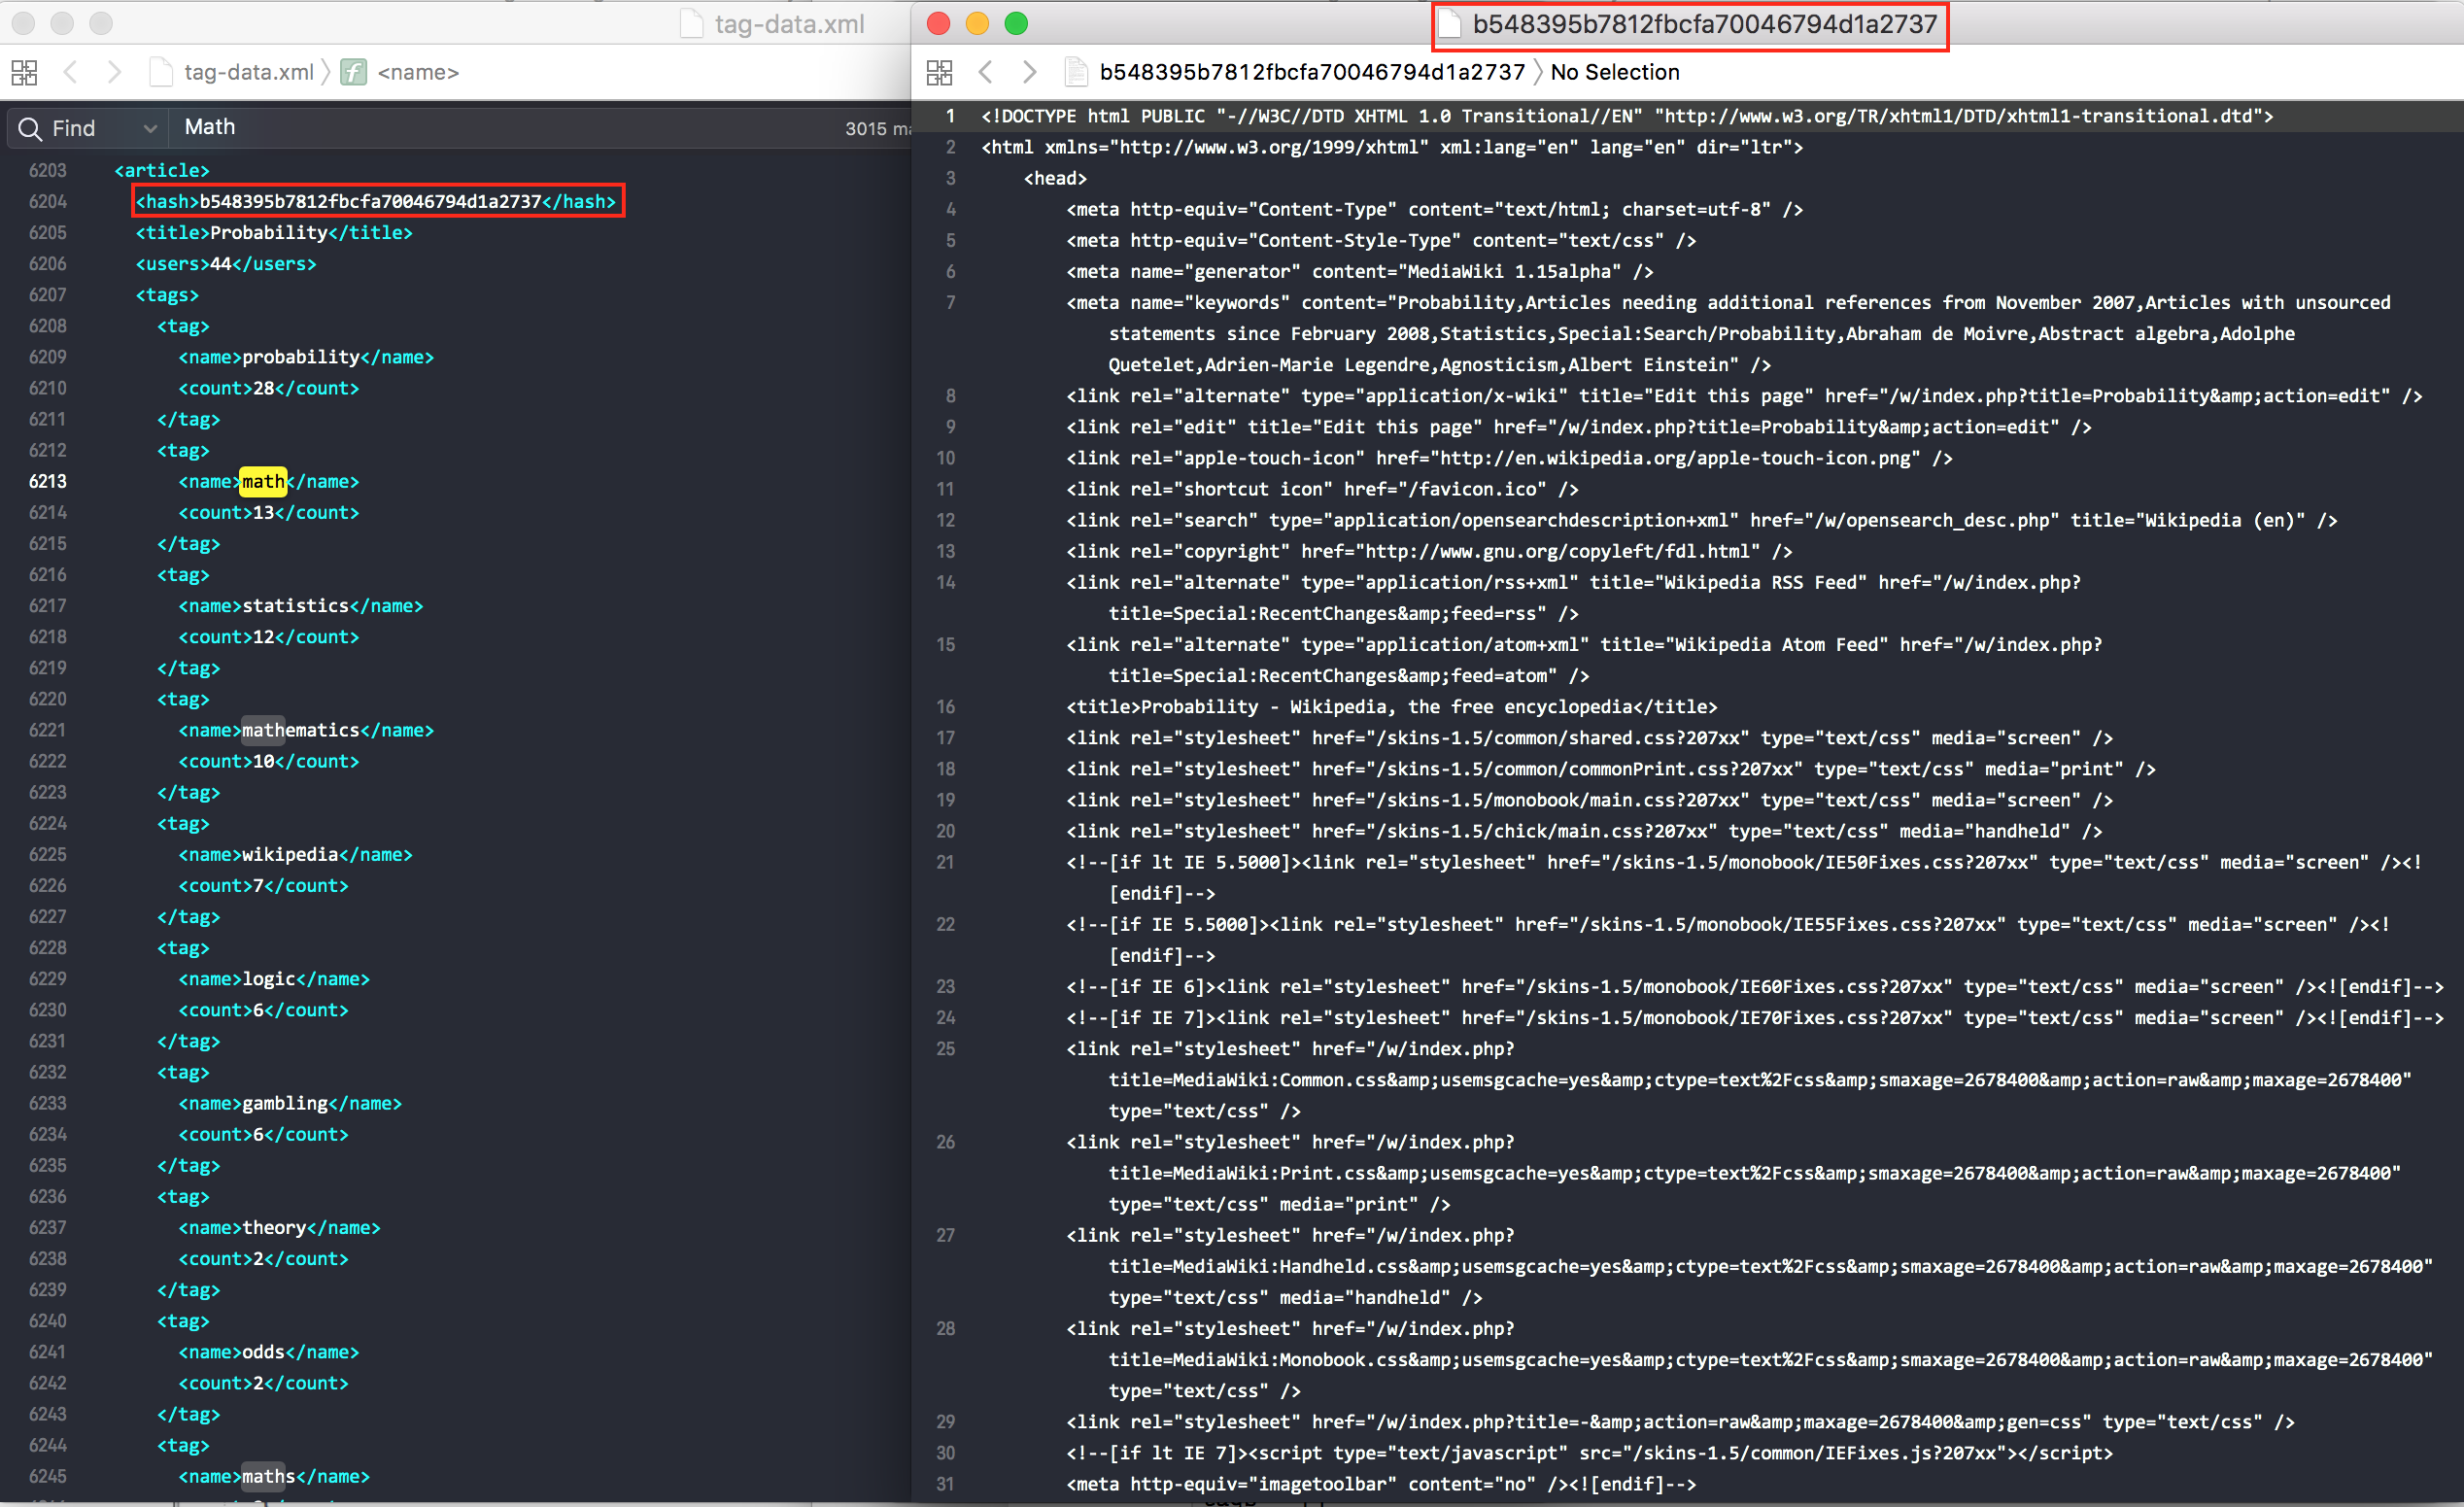

In [210]:
Image(filename = PATH_TO_DATASET + 'dataset_look.png')

## 1.1 Process tag-data.xml file

In [224]:
def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

In [413]:
"Read xml file and parse to dataframe"

parsed_xml = et.parse(PATH_TO_DATASET + "tag-data.xml")

hashes = []
titles = []
tags = []
for node in parsed_xml.getroot():           #for each article
    ha = getvalueofnode(node.find('hash'))  #take the unique hash
    ti = getvalueofnode(node.find('title')) #take the title
    if node.find('tags'):                   #take all tags that this article belongs to 
        temp = []
        for tag in node.find('tags').getchildren():
            temp.append(getvalueofnode(tag.find('name')))
    hashes.append(ha)
    titles.append(ti)
    tags.append(temp)
        
data = pd.DataFrame({
            'hash': hashes,
            'title': titles,
            'tags': tags
})

data.head()

,hash,tags,title
0,f9c3db3ffe088a3f42bdb544e5fc60a1,"[font, history, fonts, typography, designer, d...",Hermann Zapf
1,5619983c9b25f98d04bbe93cf7525b16,"[music, wikipedia, humor, reference, usa, soun...",Yakety Sax
2,2e171c3bf24e046ab812255a904c9b3d,"[tools, hardware, reference, wikipedia, wiki, ...",Torx
3,472ff0ae272e27710e978f773732787f,"[books, writer, people, wikipedia, writing, th...",Tom Robbins
4,f1993e5f9cf2526c7acb8caded787929,"[amazon, webservices, aws, cloud, web, ecommer...",Amazon Web Services


In [414]:
data.tail()

,hash,tags,title
20759,dd4982dd78a1f598e47cfb96a22d8a6e,"[palestine, israel, middleeast, politics, hist...",Palestine
20760,2bf83ccb847f12da014a101f1e96a20b,"[color, srgb, colour, reference, wikipedia, we...",sRGB
20761,63377fae63a95eafc2751b7ee63ad792,"[politics, reference, legislative, people, gov...",United States Senate
20762,65094b6cb7cf713b0a4db5014e2f192e,"[art, davinci, wikipedia, vitruvian, drawing, ...",Vitruvian Man
20763,3ac5d7a36f10add5a88968dc50858012,"[canon, eos, photo, photography, xti, 400d, ca...",Canon EOS 400D


Since an article can have multiple tags. I have to find a solution to assign only one tag(label) to any article.  
But, first, let take a look to tags frequency.

In [353]:
def plot_term_frequency(df, col, n_terms):
    set_size()

    terms = []

    for texts in df[col]:
        for text in texts:
            terms.append(text)

    plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:n_terms].to_frame()
    sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',n_terms))
    plt.title('Top tags frequency')
    fig=plt.gcf()
    fig.set_size_inches(20,15)
    plt.show()

/Users/Cescnghia/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


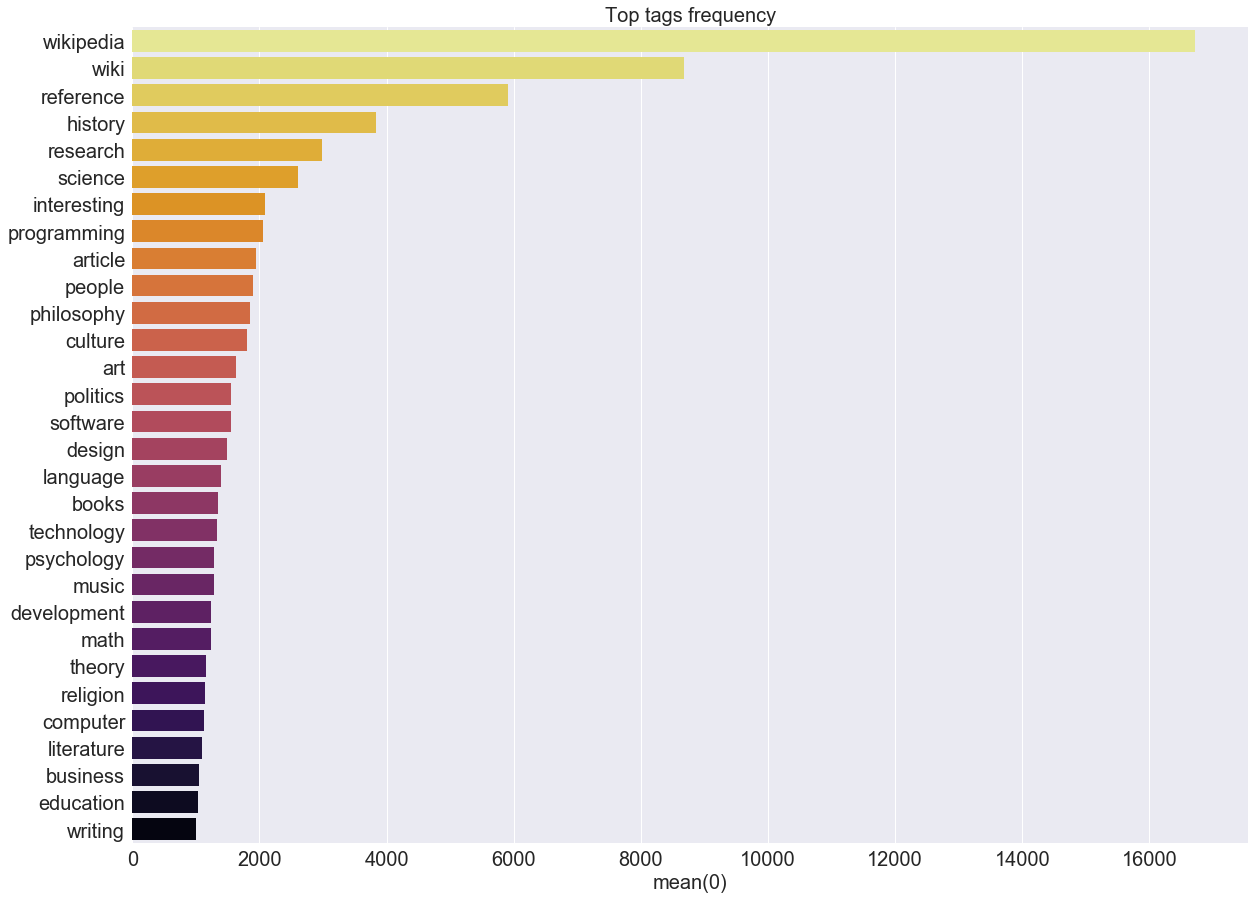

In [354]:
plot_term_frequency(data, 'tags', n_terms=30)

OK! We can see some interesting categories. Let try to find the articles of `music`, `politics`, `math`, `culture`... such that each article has only one unique category, also, if article A belongs to `music` and `culture` then we have to drop article A out of our dataset.

In [415]:
categories_chosen = set(['music', 'politics','math','philosophy',
                         'technology','design','culture'])

In [393]:
def common_elem_set(set1, set2):
    """
        - Input : set1 and set2 st both has only one common element
        - Output: common element
    """
    return set(set1) - (set(set1) - set(set2))

In [394]:
def find_unique_tag(row):
    tags = set(row['tags'])
    if tags is not None:
        if len(categories_chosen.intersection(tags)) == 1:
            return list(common_elem_set(categories_chosen, tags))[0]
        else:
            return 'NOT_UNIQUE'
    else :
        return 'NOT_UNIQUE'

In [416]:
data['label'] = data.apply(find_unique_tag, 1)
data.head()

,hash,tags,title,label
0,f9c3db3ffe088a3f42bdb544e5fc60a1,"[font, history, fonts, typography, designer, d...",Hermann Zapf,design
1,5619983c9b25f98d04bbe93cf7525b16,"[music, wikipedia, humor, reference, usa, soun...",Yakety Sax,music
2,2e171c3bf24e046ab812255a904c9b3d,"[tools, hardware, reference, wikipedia, wiki, ...",Torx,NOT_UNIQUE
3,472ff0ae272e27710e978f773732787f,"[books, writer, people, wikipedia, writing, th...",Tom Robbins,philosophy
4,f1993e5f9cf2526c7acb8caded787929,"[amazon, webservices, aws, cloud, web, ecommer...",Amazon Web Services,NOT_UNIQUE


In [418]:
data = data[data['label'] != 'NOT_UNIQUE']
#error in tag-data.xml line 1648437 hash = 'css'
data = data[data['hash'] != 'css']
#error in tag-data.xml line 1682323 hash = 'files'
data = data[data['hash'] != 'files']
data = data.reset_index().drop(labels=['index','tags'], axis=1)

data.head()

,hash,title,label
0,f9c3db3ffe088a3f42bdb544e5fc60a1,Hermann Zapf,design
1,5619983c9b25f98d04bbe93cf7525b16,Yakety Sax,music
2,472ff0ae272e27710e978f773732787f,Tom Robbins,philosophy
3,719dd9e3587f765682f2e6cbac68bd1e,The Tale of Genji,culture
4,85e480f085edc5116ef2f971b0332314,Srinivasa Ramanujan,math


In [419]:
data.to_csv('hello.csv', columns=['hash'])

In [420]:
for cat in categories_chosen:
    cat_df = data[data['label']==cat]
    print('Category *{c}* has {n} articles'.format(c=cat, n=len(cat_df)))

Category *design* has 987 articles
Category *technology* has 900 articles
Category *math* has 896 articles
Category *culture* has 976 articles
Category *politics* has 960 articles
Category *philosophy* has 1047 articles
Category *music* has 973 articles


In [421]:
len(data['hash'].unique()) == len(data)

True

In [422]:
len(data['label'].unique()) == len(categories_chosen)

True

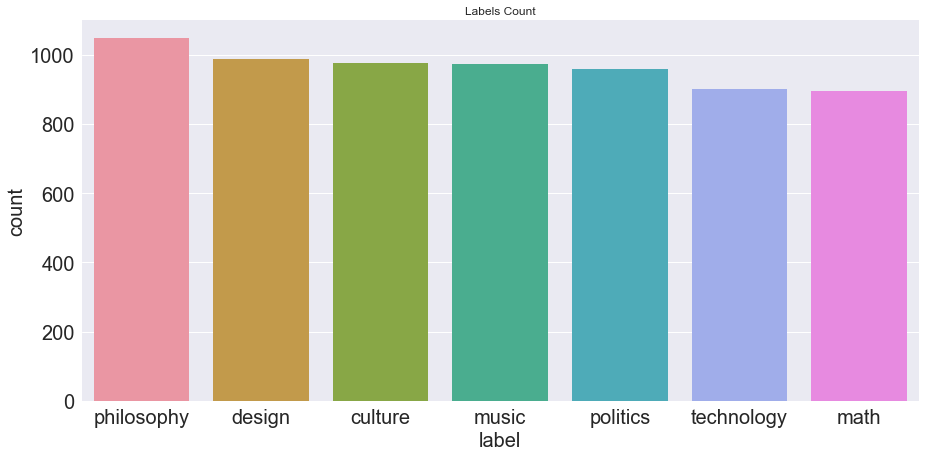

In [423]:
set_size()
plt.subplots(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(x=data['label'],order=data['label'].value_counts().index)
plt.title('Categories count')
plt.show()

## 1.2 Process html files

Now, for each article we read and parse the content to dataframe

In [424]:
def parse_content(hash_):
    f = codecs.open(PATH_TO_DATASET + "documents/" + hash_, 'r').read()
    soup = BeautifulSoup(f, 'lxml')
    content = [p.text for p in soup.find_all('p')]
    
    return content

In [425]:
data['raw_text'] = data['hash'].apply(parse_content)
data.head()

,hash,title,label,raw_text
0,f9c3db3ffe088a3f42bdb544e5fc60a1,Hermann Zapf,design,"[Hermann Zapf (born November 8, 1918) is a Ger..."
1,5619983c9b25f98d04bbe93cf7525b16,Yakety Sax,music,"[""Yakety Sax"" is a 1963 45 rpm single written ..."
2,472ff0ae272e27710e978f773732787f,Tom Robbins,philosophy,"[Thomas Eugene Robbins (born July 22, 1936 in ..."
3,719dd9e3587f765682f2e6cbac68bd1e,The Tale of Genji,culture,"[The Tale of Genji (源氏物語 ,Genji Monogatari?) i..."
4,85e480f085edc5116ef2f971b0332314,Srinivasa Ramanujan,math,[Mock theta functions\nRamanujan prime\nRamanu...


In [433]:
data.iloc[20]['raw_text']

['Probability, or chance, is a way of expressing knowledge or belief that an event will occur or has occurred. In mathematics the concept has been given an exact meaning in probability theory, that is used extensively in such areas of study as mathematics, statistics, finance, gambling, science, and philosophy to draw conclusions about the likelihood of potential events and the underlying mechanics of complex systems.',
 '',
 'The word probability does not have a consistent direct definition. In fact, there are two broad categories of probability interpretations, whose adherents possess different (and sometimes conflicting) views about the fundamental nature of probability:',
 '',
 "The word probability derives from probity, a measure of the authority of a witness in a legal case in Europe, and often correlated with the witness's nobility. In a sense, this differs much from the modern meaning of probability, which, in contrast, is used as a measure of the weight of empirical evidence, 

## 1.3 Processed text

In [ ]:
data = data.drop(labels=['hash','title'], axis=1)
data.head()

In [483]:
def standardize_text(df, text_field):
    
    """ 
        Input:
            - df: data's dataframe
            - text_field: column that we want to standardize
        Output:
            - dataframe contains `standardized` column
    """
    
    #urls_re = r'http\S+' #urls
    ht_re = r'#\S+'      #hashtags
    at_re = r'@\S+'      #@
    nb_re = " \d+"       #numbers
    
    
    punctuations = ["/","(",")","\\","|", "$", "£", ":",",",";","?", "!", "[", "]", "{","}"]
    
    new_text = []
    for texts in df[text_field]:
        
        # change ['hello John.', 'What are you doing?.', '', 'Do you want a coffee?.']
        # to     'hello John. What are you doing?. Do you want a coffee?.'
        texts = ' '.join(texts)
        temp = ''
        for text in texts.split('.'):

            text = text.replace("\\n"," ").replace("\n", " ").replace("\'", " ") \
                       .replace("-"," ").replace("_"," ").replace('\xa0'," ").replace('"', " ")

            for x in punctuations:
                text = text.replace(x , " ")

            #text = re.sub(urls_re , " ", text)
            #print(text)
            text = re.sub(ht_re   , " ", text)
            text = re.sub(at_re   , " ", text)
            text = re.sub(nb_re   , " ", text)
            
            
            text = text.lower()
            #text = text.replace("http"," ")
            temp += text + '.'
        new_text.append(temp)
    
    df['standardized_text'] = new_text
    return df

In [484]:
data = standardize_text(data, 'raw_text')
data.head()

In [510]:
def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def processing(sentence, tokenizer, stop, lemmatiser):
    "Input is a sentence"
    
    "Tokenization"
    sentence = tokenizer.tokenize(sentence)
    
    "Lemmatization"
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    
    "Stopwords removing"
    sentence = [x for x in sentence if x not in stop ]
    
    return ' '.join(sentence)

def processing_text(df, text_field):
    lemmatiser = WordNetLemmatizer()
    stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    processed_text = []
    for text in df[text_field]:
        temp = ''
        # Processed one sentence at a time
        for te in text.split('.'):
            temp += processing(te, tokenizer, stop, lemmatiser) + ' '
        processed_text.append(temp)
    df['processed_text'] = processed_text
    return df

In [511]:
start_time = time.time()
data = processing_text(data, 'standardized_text')
print("Processed all articles take %s seconds" % (time.time() - start_time))

data.head()

Processed all articles take 838.4002618789673 seconds


,hash,title,label,raw_text,standardized_text,processed_text
0,f9c3db3ffe088a3f42bdb544e5fc60a1,Hermann Zapf,design,"[Hermann Zapf (born November 8, 1918) is a Ger...",hermann zapf born november is a german ty...,hermann zapf born november german typeface des...
1,5619983c9b25f98d04bbe93cf7525b16,Yakety Sax,music,"[""Yakety Sax"" is a 1963 45 rpm single written ...",yakety sax is a rpm single written by boot...,yakety sax rpm single write boot randolph jame...
2,472ff0ae272e27710e978f773732787f,Tom Robbins,philosophy,"[Thomas Eugene Robbins (born July 22, 1936 in ...",thomas eugene robbins born july in blowing...,thomas eugene robbins bear july blow rock nort...
3,719dd9e3587f765682f2e6cbac68bd1e,The Tale of Genji,culture,"[The Tale of Genji (源氏物語 ,Genji Monogatari?) i...",the tale of genji 源氏物語 genji monogatari is...,tale genji 源氏物語 genji monogatari classic work ...
4,85e480f085edc5116ef2f971b0332314,Srinivasa Ramanujan,math,[Mock theta functions\nRamanujan prime\nRamanu...,mock theta functions ramanujan prime ramanujan...,mock theta function ramanujan prime ramanujan ...


In [512]:
data.iloc[20]['raw_text']

['Probability, or chance, is a way of expressing knowledge or belief that an event will occur or has occurred. In mathematics the concept has been given an exact meaning in probability theory, that is used extensively in such areas of study as mathematics, statistics, finance, gambling, science, and philosophy to draw conclusions about the likelihood of potential events and the underlying mechanics of complex systems.',
 '',
 'The word probability does not have a consistent direct definition. In fact, there are two broad categories of probability interpretations, whose adherents possess different (and sometimes conflicting) views about the fundamental nature of probability:',
 '',
 "The word probability derives from probity, a measure of the authority of a witness in a legal case in Europe, and often correlated with the witness's nobility. In a sense, this differs much from the modern meaning of probability, which, in contrast, is used as a measure of the weight of empirical evidence, 

In [513]:
data.iloc[20]['standardized_text']

'probability  or chance  is a way of expressing knowledge or belief that an event will occur or has occurred. in mathematics the concept has been given an exact meaning in probability theory  that is used extensively in such areas of study as mathematics  statistics  finance  gambling  science  and philosophy to draw conclusions about the likelihood of potential events and the underlying mechanics of complex systems.  the word probability does not have a consistent direct definition. in fact  there are two broad categories of probability interpretations  whose adherents possess different  and sometimes conflicting  views about the fundamental nature of probability   the word probability derives from probity  a measure of the authority of a witness in a legal case in europe  and often correlated with the witness s nobility. in a sense  this differs much from the modern meaning of probability  which  in contrast  is used as a measure of the weight of empirical evidence  and is arrived at

In [514]:
data.iloc[20]['processed_text']

'probability chance way express knowledge belief event occur occur mathematics concept give exact meaning probability theory use extensively area study mathematics statistic finance gamble science philosophy draw conclusion likelihood potential event underlying mechanic complex system word probability consistent direct definition fact broad category probability interpretation adherent possess different sometimes conflicting view fundamental nature probability word probability derive probity measure authority witness legal case europe often correlate witness nobility sense differs much modern meaning probability contrast use measure weight empirical evidence arrive inductive reasoning statistical inference scientific study probability modern development gambling show interest quantify idea probability millennium exact mathematical description use problem arose much later accord richard jeffrey middle seventeenth century term probable latin probabilis mean approvable apply sense univocal

In [516]:
data['length'] = data['processed_text'].apply(lambda x : len(x.split()))

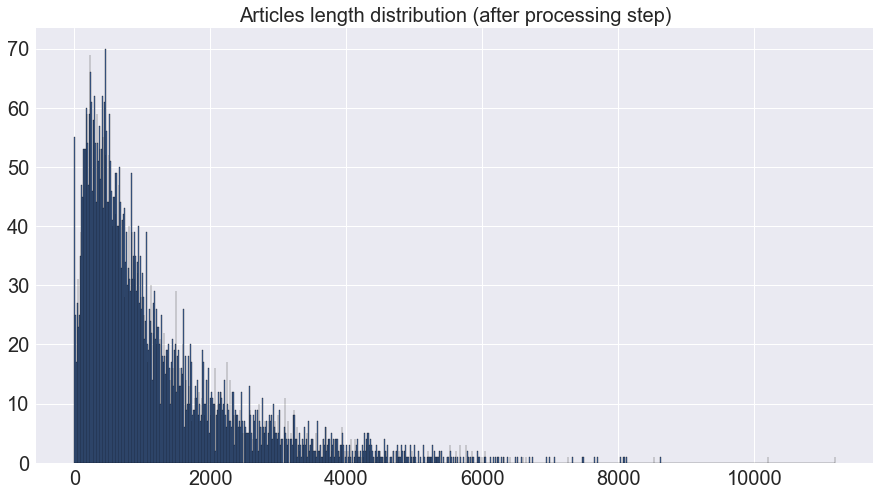

In [518]:
set_size()
plt.subplots(figsize=(15,8))
data['length'].hist(bins=1000,edgecolor='black')
plt.title('Articles length distribution (after processing step)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

I decided to drop articles where length is smaller than 50.

In [532]:
print('Number of articles: ',len(data))
print('Number of articles(length bigger than 50): ',len(data[data['length']>=50]))

Number of articles:  6739
Number of articles(length bigger than 50):  6606


In [537]:
data = data[data['length'] >= 50]
data = data.reset_index().drop(labels=['index','raw_text','standardized_text'], axis=1)
"Write to disk"
data.to_csv(PATH_TO_DATASET + 'processed_text.csv', index=False)
data.head()

,hash,title,label,processed_text,length
0,f9c3db3ffe088a3f42bdb544e5fc60a1,Hermann Zapf,design,hermann zapf born november german typeface des...,1251
1,5619983c9b25f98d04bbe93cf7525b16,Yakety Sax,music,yakety sax rpm single write boot randolph jame...,163
2,472ff0ae272e27710e978f773732787f,Tom Robbins,philosophy,thomas eugene robbins bear july blow rock nort...,226
3,719dd9e3587f765682f2e6cbac68bd1e,The Tale of Genji,culture,tale genji 源氏物語 genji monogatari classic work ...,2022
4,85e480f085edc5116ef2f971b0332314,Srinivasa Ramanujan,math,mock theta function ramanujan prime ramanujan ...,2744


# 2 Features Generating

In [596]:
"""Create TF matrix (result is a 6606 x vocab_size sparse matrix)
   Max DF: ignore terms that have a document frequency strictly higher than this threshold 
   Min DF: ignore terms that have a document frequency strictly lower  than this threshold 
   max_features: maximum number of features (terms) we decide for the design matrix
"""

vocab_size = 2000

tf_vectorizer = CountVectorizer(max_features=vocab_size)
tf = tf_vectorizer.fit_transform(data['processed_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

"""
    Create TFIDF matrix (result is a 6606 x vocab_size sparse matrix)
"""

tfidf_vectorizer = TfidfVectorizer(max_features=vocab_size)
tfidf = tfidf_vectorizer.fit_transform(data['processed_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [746]:
tf_matrix    = tf.toarray()*1.0 #parse to float
tfidf_matrix = tfidf.toarray()

data['TF']    = [x.reshape(1,vocab_size) for x in tf_matrix]
data['TFIDF'] = [x.reshape(1,vocab_size) for x in tfidf_matrix]

In [747]:
data.head(1)

,hash,title,label,processed_text,length,TF,TFIDF
0,f9c3db3ffe088a3f42bdb544e5fc60a1,Hermann Zapf,design,hermann zapf born november german typeface des...,1251,"[[1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[0.028195090321521805, 0.0, 0.077787082265668..."


In [748]:
data.iloc[4]['TF']

array([[0., 2., 2., ..., 0., 0., 0.]])

In [749]:
data.iloc[4]['TFIDF']

array([[0.        , 0.01851222, 0.01675366, ..., 0.        , 0.        ,
        0.        ]])

# 3 Autoencoder

In [672]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable

In [873]:
class AutoEncoder(nn.Module):
    def __init__(self, original_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        
            """  original_dim=>500=>250=>64=>latent_dim=>64=>250=>500=>1000=>original_dim
                 ---------------ENCODER----------------
                                             --------------------DECODER------------------    
            """
        
        "Encoder"
        self.encoder = nn.Sequential(
            nn.Linear(original_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # compress to latent_dim features
        )
        
        "Decoder"
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, original_dim),
           # nn.Sigmoid()      # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [694]:
def flatten(array):
    return [s for sublist in array for s in sublist]

In [753]:
def get_batch(X, batch_size, shuffle=True):
    data_size = len(X)
    
    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_x = X[shuffle_indices]
    else:
        shuffled_x = X

    num_batches = int(data_size / batch_size) + 1
    
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1)*batch_size, data_size)
        if start_index != end_index:
            tX = shuffled_x[start_index:end_index]
            tX = flatten(tX)
            yield torch.Tensor(tX)

In [828]:
def train(X, nb_epochs, lr, batch_size, original_dim, latent_dim):
    
    autoencoder = AutoEncoder(original_dim, latent_dim)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(nb_epochs):
        for step, x in enumerate(get_batch(X, batch_size)):

            vab_x = Variable(x)                   #var_x.size= torch.Size([BATCH, original_dim])
            encoded, decoded = autoencoder(vab_x) #encoded.size = torch.Size([BATCH, latent_dim])
            loss = criterion(decoded, vab_x)      # mean square error
            optimizer.zero_grad()                 # clear gradients for this training step
            loss.backward()                       # backpropagation, compute gradients
            optimizer.step()                      # apply gradients

            if step % 20 == 0:
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])
    
    return autoencoder

# 4 Classify using Autoencoder

In [870]:
autoencoder_classification = train(X=data['TF'], nb_epochs=20, lr=1e-3, batch_size=100, \
                                   original_dim=vocab_size, latent_dim=10)

Epoch:  0 | train loss: 5.6341
Epoch:  0 | train loss: 4.7953
Epoch:  0 | train loss: 3.0494
Epoch:  0 | train loss: 3.8825
Epoch:  1 | train loss: 5.1199
Epoch:  1 | train loss: 3.3752
Epoch:  1 | train loss: 3.5569
Epoch:  1 | train loss: 4.1633
Epoch:  2 | train loss: 3.0292
Epoch:  2 | train loss: 3.3362
Epoch:  2 | train loss: 3.5574
Epoch:  2 | train loss: 5.4921
Epoch:  3 | train loss: 2.8606
Epoch:  3 | train loss: 2.9969
Epoch:  3 | train loss: 3.4975
Epoch:  3 | train loss: 3.6110
Epoch:  4 | train loss: 3.3281
Epoch:  4 | train loss: 7.1784
Epoch:  4 | train loss: 5.3256
Epoch:  4 | train loss: 3.2999
Epoch:  5 | train loss: 4.0045
Epoch:  5 | train loss: 6.2771
Epoch:  5 | train loss: 3.2532
Epoch:  5 | train loss: 4.5334
Epoch:  6 | train loss: 5.6425
Epoch:  6 | train loss: 3.7672
Epoch:  6 | train loss: 2.3412
Epoch:  6 | train loss: 3.1929
Epoch:  7 | train loss: 3.3242
Epoch:  7 | train loss: 2.4039
Epoch:  7 | train loss: 4.2354
Epoch:  7 | train loss: 2.8412
Epoch:  

In [ ]:
X = autoencoder_classification(Variable(torch.Tensor(flatten(data['TF']))))
y = data['label']

# 5 PCA vs Latent dimension of Autoencoder

In [883]:
classes = list(categories_chosen)
classes

['design', 'technology', 'math', 'culture', 'politics', 'philosophy', 'music']

In [884]:
def plot_PCA(X, y, pca):
        set_size()
        plt.figure(figsize=(16, 16)) 
        labels = [classes.index(label) for label in y]
        colors = ['blue', 'green', 'red', 'cyan', 'purple', 'yellow','black']
        
        if pca:
            plt.title('PCA')
            X = [x.tolist()[0] for x in X]
            pca = PCA(n_components=2)
            pca_scores = pca.fit_transform(np.array(X))
            plt.scatter(pca_scores[:,0], pca_scores[:,1], s=11, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
        else:
            plt.title('Latent dimension from Autoencoder')
            plt.scatter(list(X[:,0]), list(X[:,1]), s=11, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
        
        
        design_patch = mpatches.Patch(color='blue', label='design')
        technology_patch = mpatches.Patch(color='green', label='technology')
        math_patch = mpatches.Patch(color='red', label='math')
        culture_patch = mpatches.Patch(color='cyan', label='culture')
        politics_patch = mpatches.Patch(color='purple', label='politics')
        philosophy_patch = mpatches.Patch(color='yellow', label='philosophy')
        music_patch = mpatches.Patch(color='black', label='music')
        
        handles=[design_patch, technology_patch, math_patch, 
                 culture_patch, politics_patch, philosophy_patch, music_patch]
        plt.legend(handles=handles, prop={'size': 20})
        plt.show()

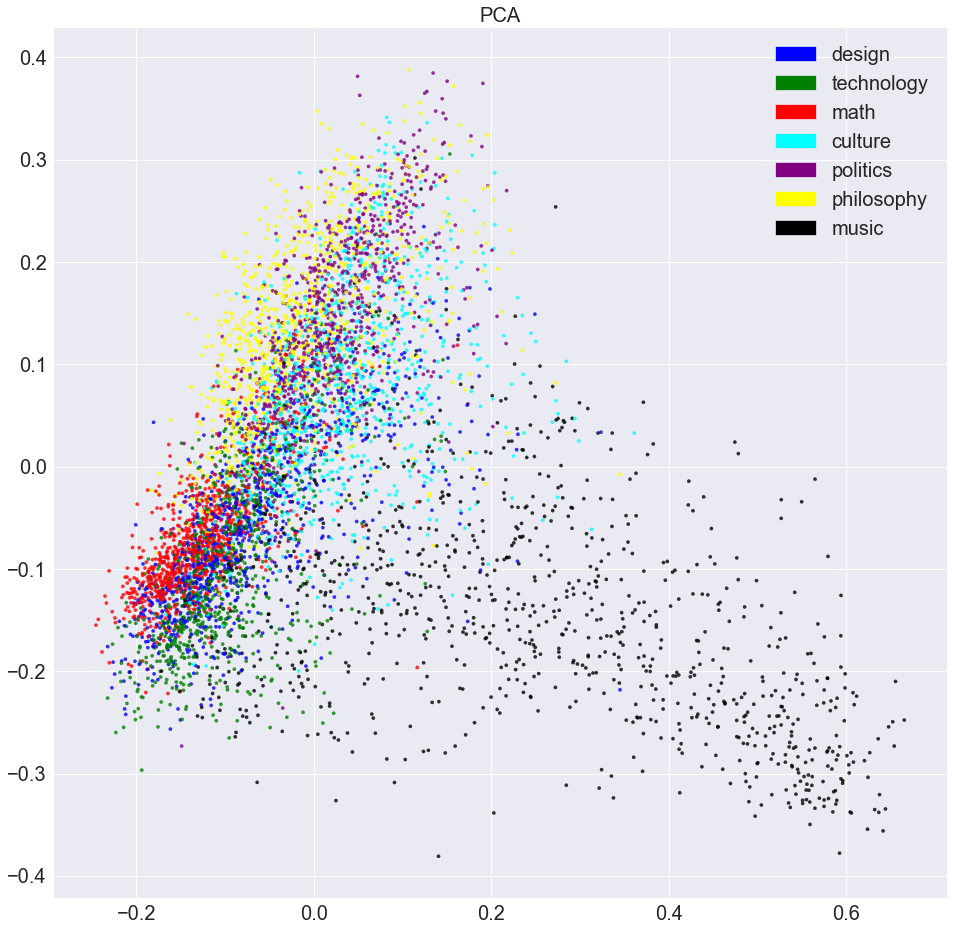

In [837]:
plot_PCA(data['TFIDF'], data['label'], pca=True)

In [874]:
autoencoder = train(X=data['TF'], nb_epochs=20, lr=.001, \
                batch_size=100, original_dim=vocab_size, latent_dim=2)

Epoch:  0 | train loss: 3.3434
Epoch:  0 | train loss: 3.7367
Epoch:  0 | train loss: 3.8329
Epoch:  0 | train loss: 3.6072
Epoch:  1 | train loss: 3.1873
Epoch:  1 | train loss: 3.6761
Epoch:  1 | train loss: 4.0137
Epoch:  1 | train loss: 4.6477
Epoch:  2 | train loss: 2.8365
Epoch:  2 | train loss: 4.0094
Epoch:  2 | train loss: 3.8581
Epoch:  2 | train loss: 3.2668
Epoch:  3 | train loss: 4.3872
Epoch:  3 | train loss: 4.4530
Epoch:  3 | train loss: 3.4836
Epoch:  3 | train loss: 4.2736
Epoch:  4 | train loss: 3.2153
Epoch:  4 | train loss: 4.9367
Epoch:  4 | train loss: 3.3620
Epoch:  4 | train loss: 3.6387
Epoch:  5 | train loss: 4.8675
Epoch:  5 | train loss: 2.8747
Epoch:  5 | train loss: 3.4813
Epoch:  5 | train loss: 3.6738
Epoch:  6 | train loss: 3.6484
Epoch:  6 | train loss: 3.1233
Epoch:  6 | train loss: 4.0493
Epoch:  6 | train loss: 4.9230
Epoch:  7 | train loss: 3.4427
Epoch:  7 | train loss: 3.7254
Epoch:  7 | train loss: 2.9765
Epoch:  7 | train loss: 2.8198
Epoch:  

In [875]:
tensor_data = torch.Tensor(flatten(data['TF']))
encoded_data, decoded_data = autoencoder(Variable(tensor_data))

plot_PCA(encoded_data.data, data['label'], pca=False)

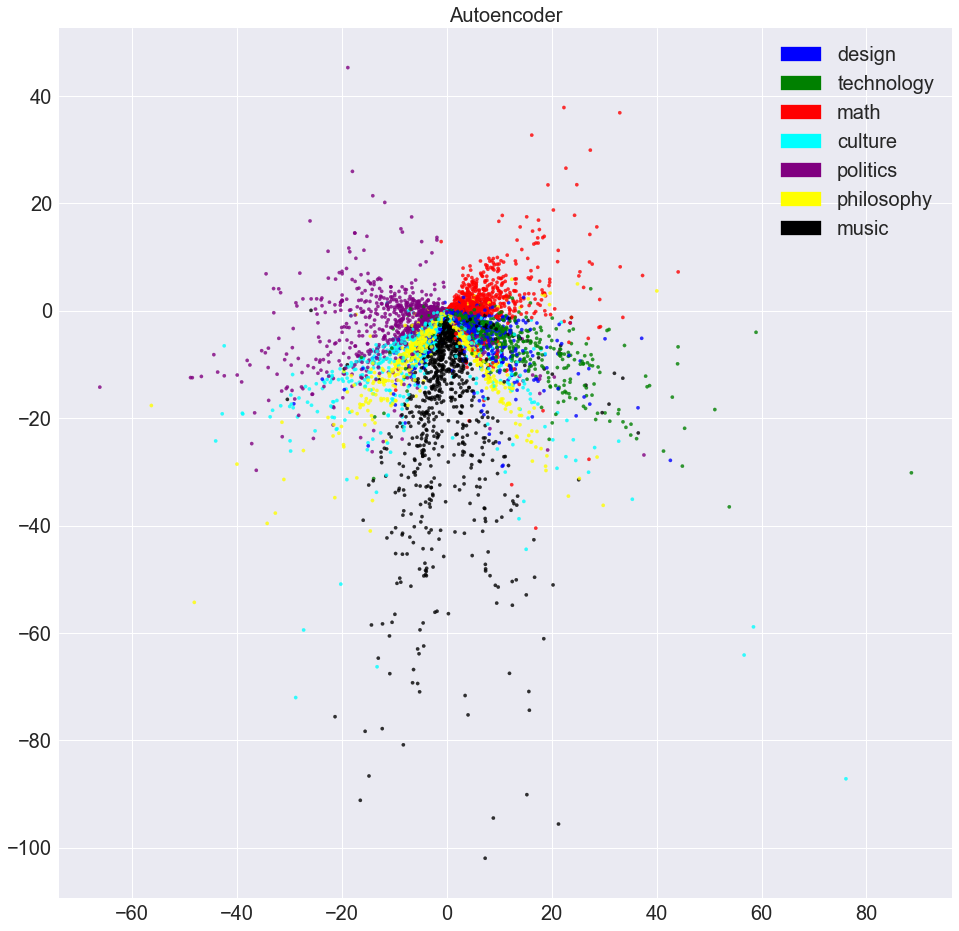

False